In [148]:
import numpy as np

data = {
    "small": {
        "starry": np.load("data/starry_0.01.npz", allow_pickle=True),
        "jax": np.load("data/jax_0.01.npz", allow_pickle=True),
        "numerical": np.load("data/numerical_0.01.npz", allow_pickle=True),
    },
    "large": {
        "starry": np.load("data/starry_100.npz", allow_pickle=True),
        "jax": np.load("data/jax_100.npz", allow_pickle=True),
        "numerical": np.load("data/numerical_100.npz", allow_pickle=True),
    },
}

S = {
    "small": {
        "starry": data["small"]["starry"]["S"],
        "jax": data["small"]["jax"]["S"].T,
        "numerical": data["small"]["numerical"]["S"],
    },
    "large": {
        "starry": data["large"]["starry"]["S"],
        "jax": data["large"]["jax"]["S"].T,
        "numerical": data["large"]["numerical"]["S"],
    },
}

Bs = {"small": data["small"]["jax"]["Bs"], "large": data["large"]["jax"]["Bs"]}
labels = {
    "small": data["small"]["jax"]["labels"],
    "large": data["large"]["jax"]["labels"],
}

r = {
    "small": data["small"]["jax"]["r"],
    "large": data["large"]["jax"]["r"],
}

In [149]:
S["small"]["jax"].shape, S["small"]["numerical"].shape, S["small"]["starry"].shape

((441, 250), (441, 250), (441, 250))

In [150]:
S["large"]["jax"].shape, S["large"]["numerical"].shape, S["large"]["starry"].shape

((441, 130), (441, 130), (441, 130))

In [5]:
def errors(ref, comp):
    rel = np.abs(comp - ref)
    # frac = np.abs((comp - ref) / np.nanmax([1e-9 * np.ones_like(ref), np.abs(comp)], 0))

    frac = np.abs(
        (comp - ref) / max(1e-9, np.nanmax(np.min([np.abs(ref), np.abs(comp)], 0)))
    )
    frac[rel < 1e-16] = 1e-16
    return rel, frac

In [79]:
import matplotlib.pyplot as plt


def plot_occ(b, r, ax):
    ax.set_aspect(1)
    ax.axis("off")

    occultor = plt.Circle((0, 0), 1, facecolor=("k", 0.1), edgecolor="0.8")
    ax.add_artist(occultor)
    occultor = plt.Circle((b, 0), r, facecolor=("k", 0.4), edgecolor="0.3")
    ax.add_artist(occultor)
    h = 2 * r
    ax.set_ylim(-h, h)
    ax.set_xlim(-h + b, h + b)

/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_35990/651220410.py:6: RuntimeWarning: All-NaN slice encountered
  (comp - ref) / max(1e-9, np.nanmax(np.min([np.abs(ref), np.abs(comp)], 0)))
/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_35990/651220410.py:6: RuntimeWarning: All-NaN slice encountered
  (comp - ref) / max(1e-9, np.nanmax(np.min([np.abs(ref), np.abs(comp)], 0)))
/Users/lgarcia/mambaforge/envs/jaxoplanet/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lgarcia/mambaforge/envs/jaxoplanet/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


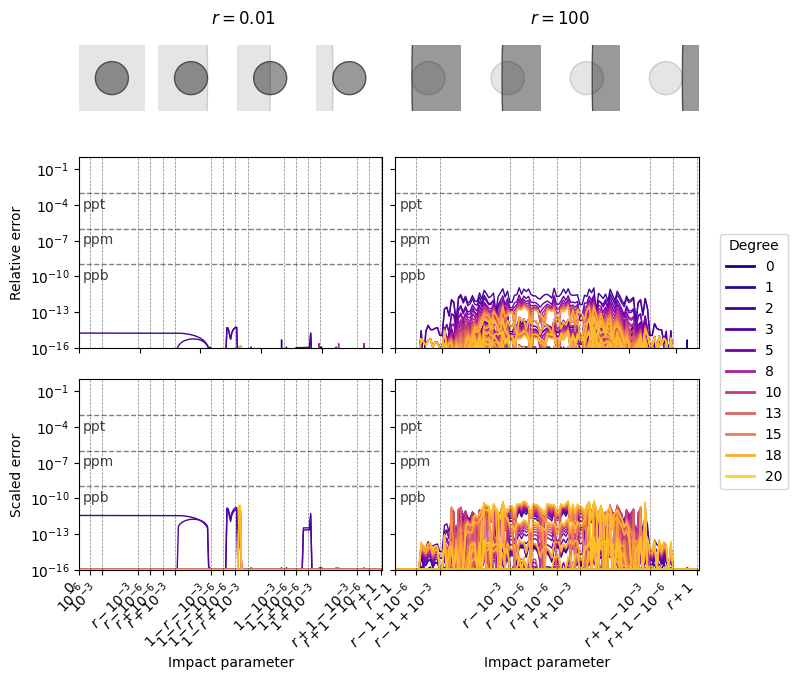

In [139]:
from matplotlib import gridspec
import matplotlib.pyplot as plt

l_arr = [0, 1, 2, 3, 5, 8, 10, 13, 15, 18, 20]

l_max = 20

cmap = plt.get_cmap("plasma")

fig = plt.figure(constrained_layout=True, figsize=(8.0, 7))

N = 8
gs = gridspec.GridSpec(3, N, figure=fig, height_ratios=[1, 2, 2])

# circles

b_vals = {
    "small": [0, 1 - r["small"], 1, 1 + r["small"]],
    "large": np.linspace(r["large"] - 1, r["large"] + 1, N // 2),
}

for i in range(N // 2):
    ax = fig.add_subplot(gs[0, i])

    if i == 0:
        ax.set_title(f"$r={r['small']}$", x=2.5, y=1.2, ha="center")

    b = b_vals["small"][i]
    plot_occ(b, r["small"], ax)
    h = 2 * r["small"]
    ax.set_ylim(-h, h)
    ax.set_xlim(-h + b, h + b)

for i in range(N // 2):
    ax = fig.add_subplot(gs[0, N // 2 + i])
    if i == 0:
        ax.set_title(f"$r={r['large']:0.0f}$", x=2.5, y=1.2, ha="center")
    b = b_vals["large"][i]
    plot_occ(b, r["large"], ax)
    h = 2.0
    ax.set_ylim(-h, h)
    ax.set_xlim(-h, h)


for i, size in enumerate(["small", "large"]):

    ax_top = fig.add_subplot(gs[1, N // 2 * i : (N // 2 * i + N // 2)])
    ax_bot = fig.add_subplot(gs[2, N // 2 * i : (N // 2 * i + N // 2)])

    n = 0
    for l in range(l_max):
        for m in range(-l, l + 1):
            if l == 0 and m != 0:
                continue
            err_rel, err_frac = errors(S[size]["numerical"][n], S[size]["jax"][n])
            ax_top.plot(err_rel, color=cmap(l / (l_max + 2)), lw=1, zorder=-1)
            ax_bot.plot(err_frac, color=cmap(l / (l_max + 2)), lw=1, zorder=-1)
            n += 1

    bs = np.concatenate(Bs[size])

    ax_top.set_yscale("log")
    ax_bot.set_yscale("log")
    ax_top.set_ylim(1e-16, 1)
    ax_bot.set_ylim(1e-16, 1)
    ax_top.set_xlim(0, len(bs))
    ax_bot.set_xlim(0, len(bs))
    ax_top.set_xticklabels([])

    bounds = np.cumsum([0] + [len(bb) for bb in Bs[size]]) - 1
    bounds[0] = 0

    for v in bounds:
        for axis in [ax_top, ax_bot]:
            axis.axvline(v, lw=0.5, color="k", alpha=0.5, zorder=10, ls="--")

    ax_bot.set_xticks(bounds)
    ax_bot.set_xticklabels(labels[size], rotation=45, fontsize=10, ha="right")

    if i == 0:
        ax_top.set_ylabel("Relative error")
        ax_bot.set_ylabel("Scaled error")

    ax_bot.set_xlabel("Impact parameter")

    if i == 1:
        ax_top.set_yticklabels([])
        ax_bot.set_yticklabels([])

    for axis in (ax_top, ax_bot):
        axis.axhline(1e-3, ls="--", lw=1, color="k", alpha=0.5)
        axis.axhline(1e-6, ls="--", lw=1, color="k", alpha=0.5)
        axis.axhline(1e-9, ls="--", lw=1, color="k", alpha=0.5)
        axis.annotate(
            "ppt",
            xy=(0, 1e-3),
            xycoords="data",
            xytext=(3, -3),
            textcoords="offset points",
            ha="left",
            va="top",
            alpha=0.75,
        )
        axis.annotate(
            "ppm",
            xy=(0, 1e-6),
            xycoords="data",
            xytext=(3, -3),
            textcoords="offset points",
            ha="left",
            va="top",
            alpha=0.75,
        )
        axis.annotate(
            "ppb",
            xy=(0, 1e-9),
            xycoords="data",
            xytext=(3, -3),
            textcoords="offset points",
            ha="left",
            va="top",
            alpha=0.75,
        )


# Dummy curves & a legend
lines = [None for l in l_arr]
leg_labels = ["%d" % l for l in l_arr]
for i, l in enumerate(l_arr):
    (lines[i],) = ax_top.plot((0, 1), (1e-20, 1e-20), color=cmap(l / (l_max + 2)), lw=2)
leg = fig.legend(
    lines, leg_labels, title="Degree", bbox_to_anchor=(0.52, 0.1, 0.5, 0.5)
)

# plt.tight_layout()

In [107]:
r["large"] + 1

101.0

In [20]:
len(Bs[size]

9

In [48]:
gs

AttributeError: 'GridSpec' object has no attribute 'shape'

In [7]:
labels

{'small': array(['$0$', '$10^{-6}$', '$10^{-3}$', '$r - 10^{-3}$', '$r - 10^{-6}$',
        '$r + 10^{-6}$', '$r + 10^{-3}$', '$1 - r - 10^{-3}$',
        '$1 - r - 10^{-6}$', '$1 - r + 10^{-6}$', '$1 - r + 10^{-3}$',
        '$1 - 10^{-3}$', '$1 - 10^{-6}$', '$1 + 10^{-6}$', '$1 + 10^{-3}$',
        '$r + 1 - 10^{-3}$', '$r + 1 - 10^{-6}$', '$r + 1$'], dtype='<U17'),
 'large': array(['$r - 1$', '$r - 1 + 10^{-6}$', '$r - 1 + 10^{-3}$',
        '$r - 10^{-3}$', '$r - 10^{-6}$', '$r + 10^{-6}$', '$r + 10^{-3}$',
        '$r + 1 - 10^{-3}$', '$r + 1 - 10^{-6}$', '$r + 1$'], dtype='<U17')}